In [77]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn

Requirement already up-to-date: mxnet~=1.7 in /usr/local/lib/python3.7/dist-packages (1.8.0.post0)
Requirement already up-to-date: gluonts in /usr/local/lib/python3.7/dist-packages (0.7.3)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import numpy as np # numpy arrays / linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px # map plot
import warnings
warnings.filterwarnings('ignore') 

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as md
%matplotlib inline
from scipy.optimize import curve_fit # predictive modeling
import seaborn as sns
import statsmodels.api as sm

import datetime
from datetime import date

In [83]:
df = pd.read_csv('/content/drive/MyDrive/dataset/country_vaccinations.csv', engine='python', header=0)
df.dropna(subset=['daily_vaccinations'],inplace=True)
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
5,Afghanistan,AFG,2021-02-27,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...


In [84]:
gm = pd.read_csv('/content/drive/MyDrive/dataset/gapminder_tidy.csv', engine='python')
gm.head()

,Country,Year,fertility,life,population,child_mortality,gdp,gdp-1,region
0,Afghanistan,1964,7.671,33.639,10474903.0,339.7,1182.0,1182.0,South Asia
1,Afghanistan,1965,7.671,34.152,10697983.0,334.1,1182.0,1168.0,South Asia
2,Afghanistan,1966,7.671,34.662,10927724.0,328.7,1168.0,1173.0,South Asia
3,Afghanistan,1967,7.671,35.170,11163656.0,323.3,1173.0,1187.0,South Asia
4,Afghanistan,1968,7.671,35.674,11411022.0,318.1,1187.0,1178.0,South Asia


In [85]:
df['country'].nunique()

189

In [86]:
df.country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Cayman Islands', 'Chile', 'China',
       'Colombia', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'England', 'Equatorial Guinea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Faeroe Islands', 'Falkland Islands',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada',
       'Guatemala', 'Guernsey', 'Guinea', 'Guyana', 'H

In [87]:
gm_max_year = gm.groupby(['Country'])['Year'].max().reset_index()

In [88]:
gm_max_year

,Country,Year
0,Afghanistan,2013
1,Albania,2013
2,Algeria,2013
3,Angola,2013
4,Antigua and Barbuda,2013
...,...,...
199,Western Sahara,2013
200,"Yemen, Rep.",2013
201,Zambia,2013
202,Zimbabwe,2013


In [89]:
gm_max = gm.merge(gm_max_year,how='inner',on=['Country','Year']) 

In [90]:
df_gm = df.merge(gm_max,how='left',left_on='country',right_on='Country')

In [91]:
df_gm.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Country,Year,fertility,life,population,child_mortality,gdp,gdp-1,region
0,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,Afghanistan,2013.0,4.9,60.947,34499915.0,96.7,1884.0,3023.0,South Asia
1,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,Afghanistan,2013.0,4.9,60.947,34499915.0,96.7,1884.0,3023.0,South Asia
2,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,Afghanistan,2013.0,4.9,60.947,34499915.0,96.7,1884.0,3023.0,South Asia
3,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,Afghanistan,2013.0,4.9,60.947,34499915.0,96.7,1884.0,3023.0,South Asia
4,Afghanistan,AFG,2021-02-27,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...,Afghanistan,2013.0,4.9,60.947,34499915.0,96.7,1884.0,3023.0,South Asia


In [92]:
df_gm['gdp_per_capita'] = df_gm['gdp'] / df_gm['population']

In [93]:
df_gm.isna().sum()

country                                   0
iso_code                                  0
date                                      0
total_vaccinations                     6224
people_vaccinated                      6885
people_fully_vaccinated                8978
daily_vaccinations_raw                 7537
daily_vaccinations                        0
total_vaccinations_per_hundred         6224
people_vaccinated_per_hundred          6885
people_fully_vaccinated_per_hundred    8978
daily_vaccinations_per_million            0
vaccines                                  0
source_name                               0
source_website                            0
Country                                3020
Year                                   3020
fertility                              3020
life                                   3020
population                             3020
child_mortality                        3358
gdp                                    3215
gdp-1                           

In [94]:
df_gm['region'] = df_gm['region'].fillna('Other')
df_gm['population'] = df_gm['population'].fillna(df_gm['population'].mean())
df_gm['life'] = df_gm['life'].fillna(df_gm['life'].mean())
df_gm['gdp'] = df_gm['gdp'].fillna(df_gm['gdp'].mean())

In [95]:
#Some data quality issues with null data
df_gm[df_gm['country']=='Indonesia'].tail()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Country,Year,fertility,life,population,child_mortality,gdp,gdp-1,region,gdp_per_capita
6532,Indonesia,IDN,2021-05-02,20172516.0,12469406.0,7703110.0,NaN,228792.0,7.38,4.56,2.82,836.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039
6533,Indonesia,IDN,2021-05-03,NaN,NaN,NaN,NaN,227754.0,NaN,NaN,NaN,833.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039
6534,Indonesia,IDN,2021-05-04,20701804.0,12699568.0,8002236.0,NaN,210194.0,7.57,4.64,2.93,768.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039
6535,Indonesia,IDN,2021-05-05,NaN,NaN,NaN,NaN,210472.0,NaN,NaN,NaN,769.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039
6536,Indonesia,IDN,2021-05-06,21367754.0,13028699.0,8339055.0,NaN,211079.0,7.81,4.76,3.05,772.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039


In [96]:
df_gm['people_fully_vaccinated_per_hundred'] =  np.where(df_gm['people_fully_vaccinated_per_hundred'].isna(),
                                                   (df_gm['total_vaccinations_per_hundred'] /2)  ,
                                                   df_gm['people_fully_vaccinated_per_hundred'])

In [97]:
df_gm[df_gm['country']=='Indonesia'].tail()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Country,Year,fertility,life,population,child_mortality,gdp,gdp-1,region,gdp_per_capita
6532,Indonesia,IDN,2021-05-02,20172516.0,12469406.0,7703110.0,NaN,228792.0,7.38,4.56,2.82,836.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039
6533,Indonesia,IDN,2021-05-03,NaN,NaN,NaN,NaN,227754.0,NaN,NaN,NaN,833.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039
6534,Indonesia,IDN,2021-05-04,20701804.0,12699568.0,8002236.0,NaN,210194.0,7.57,4.64,2.93,768.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039
6535,Indonesia,IDN,2021-05-05,NaN,NaN,NaN,NaN,210472.0,NaN,NaN,NaN,769.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039
6536,Indonesia,IDN,2021-05-06,21367754.0,13028699.0,8339055.0,NaN,211079.0,7.81,4.76,3.05,772.0,"Oxford/AstraZeneca, Sinovac",Ministry of Health,https://vaksin.kemkes.go.id/#/vaccines,Indonesia,2013.0,2.338,70.833,247188189.0,29.3,9729.0,6188.0,East Asia & Pacific,0.000039


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


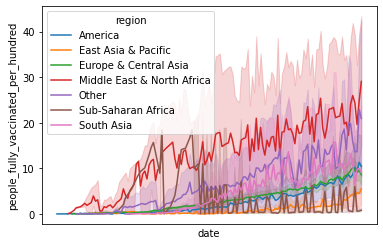

In [98]:
graph = sns.lineplot(data=df_gm.sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='region')
graph.xaxis.set_major_locator(md.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


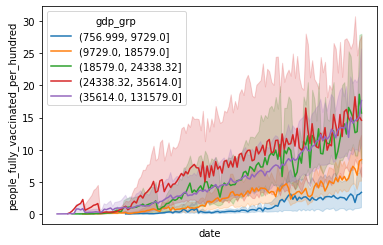

In [99]:
df_gm['gdp_grp'] = pd.qcut(df_gm['gdp'],q=5)
graph = sns.lineplot(data=df_gm.sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='gdp_grp')
graph.xaxis.set_major_locator(md.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


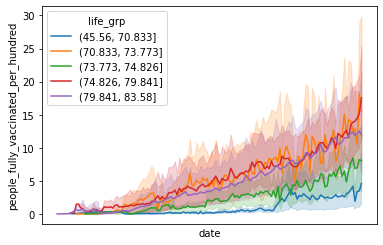

In [100]:
df_gm['life_grp'] = pd.qcut(df_gm['life'],q=5)
graph = sns.lineplot(data=df_gm.sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='life_grp')
graph.xaxis.set_major_locator(md.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


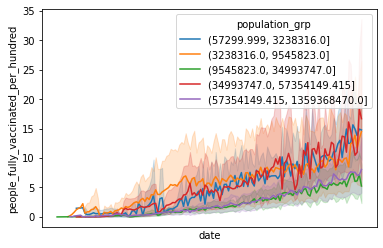

In [101]:
df_gm['population_grp'] = pd.qcut(df_gm['population'],q=5)
graph = sns.lineplot(data=df_gm.sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='population_grp')
graph.xaxis.set_major_locator(md.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


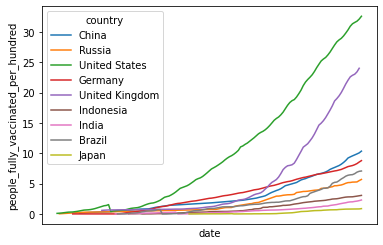

In [102]:
graph = sns.lineplot(data=df_gm[df_gm['iso_code'].isin(['GBR','IDN','BRA','RUS','DEU','JPN','IND','USA','CHN'])]
                     .sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='country')
graph.xaxis.set_major_locator(md.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


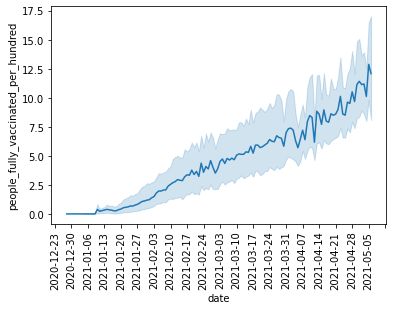

In [103]:
import matplotlib.dates as md
graph = sns.lineplot(data=df.sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred")
graph.xaxis.set_major_locator(md.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

In [104]:
df_gm['vaccines'].unique()

array(['Oxford/AstraZeneca',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, Sputnik V',
       'Sputnik V', 'Oxford/AstraZeneca, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V',
       'Pfizer/BioNTech',
       'Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Sinovac',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V',
       'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac',
       'Sinopharm/Beijing', 'Pfizer/BioNTech, Sinovac',
       'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac',
       'Moderna, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Sinopharm/Beijing',
       'Moderna, Oxford/AstraZeneca',
       'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V',
       'Covaxin, Oxford/AstraZeneca',
       'Pfizer/BioNTech, Sinopharm/Beijing',
       'O

In [105]:
df_gm['American_Vaccine'] = np.where(df_gm['vaccines'].str.contains('Johnson&Johnson|Moderna|Pfizer'),1,0)
df_gm['Russian_Vaccine'] = np.where(df_gm['vaccines'].str.contains('Sputnik V|EpiVacCorona'),1,0)
df_gm['Chinese_Vaccine'] = np.where(df_gm['vaccines'].str.contains('Sinopharm/Beijing|Sinopharm/Wuhan|Sinovac'),1,0)
df_gm['Indian_Vaccine'] = np.where(df_gm['vaccines'].str.contains('Covaxin'),1,0)
df_gm['European_Vaccine'] = np.where(df_gm['vaccines'].str.contains('Oxford|AstraZeneca|BioNTech'),1,0)

In [106]:
!pip install geopandas

In [107]:
import geopandas as gpd
## map plot based on country map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [108]:
mapped = world.set_index('iso_a3').join(df_gm.set_index('iso_code')).reset_index()

In [109]:
def graph_world(feature):
    to_be_mapped = feature
    vmin, vmax = 0,100
    fig, ax = plt.subplots(1, figsize=(25,25))

    mapped.plot(column=to_be_mapped, cmap='Blues', linewidth=0.8, ax=ax, edgecolors='0.8')
    ax.set_title('x', fontdict={'fontsize':30})
    ax.set_axis_off()

    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    cbar = fig.colorbar(sm, orientation='horizontal')

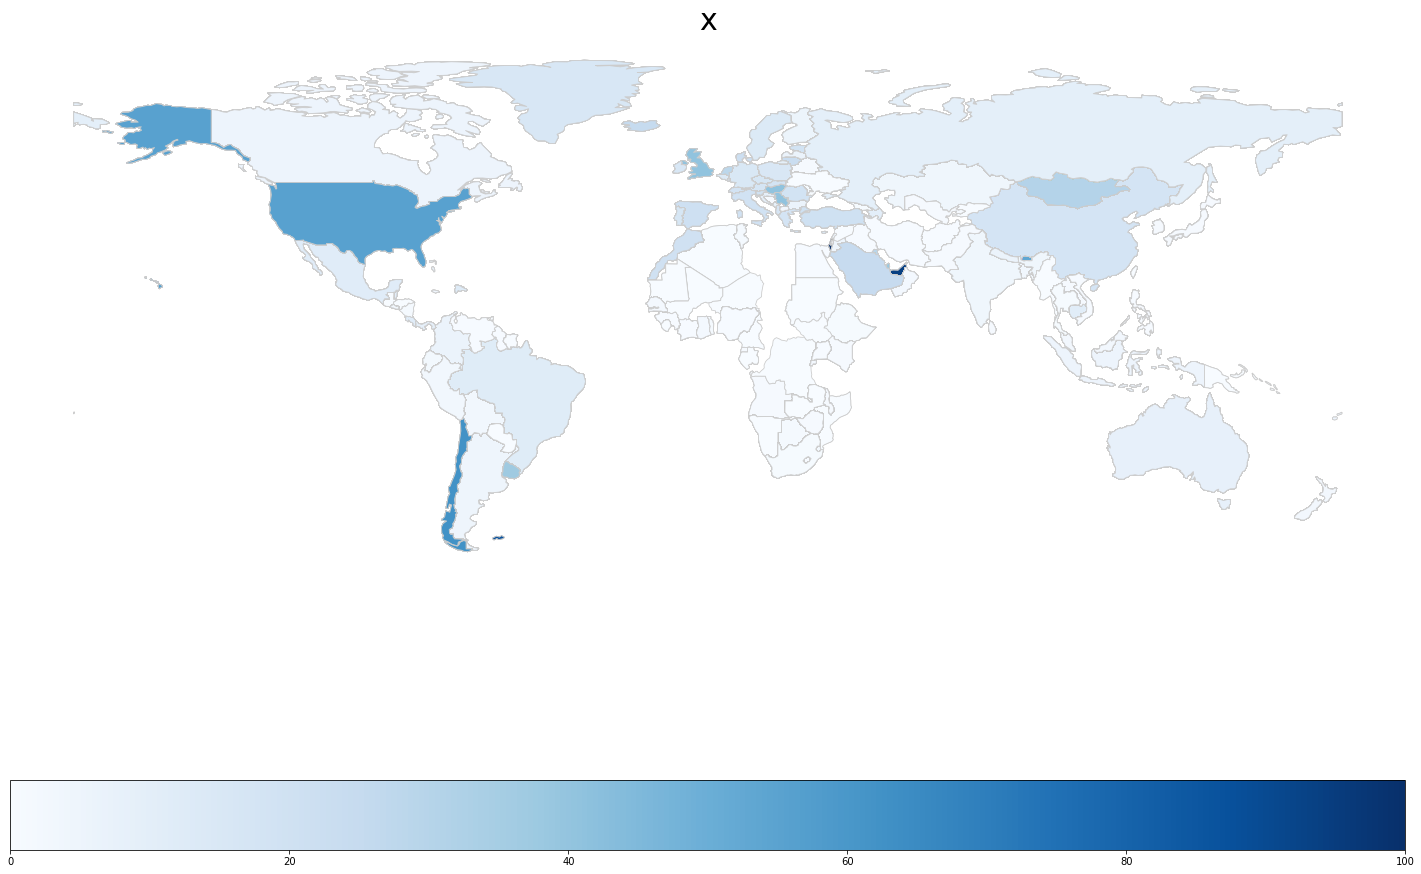

In [110]:
graph_world('people_fully_vaccinated_per_hundred')

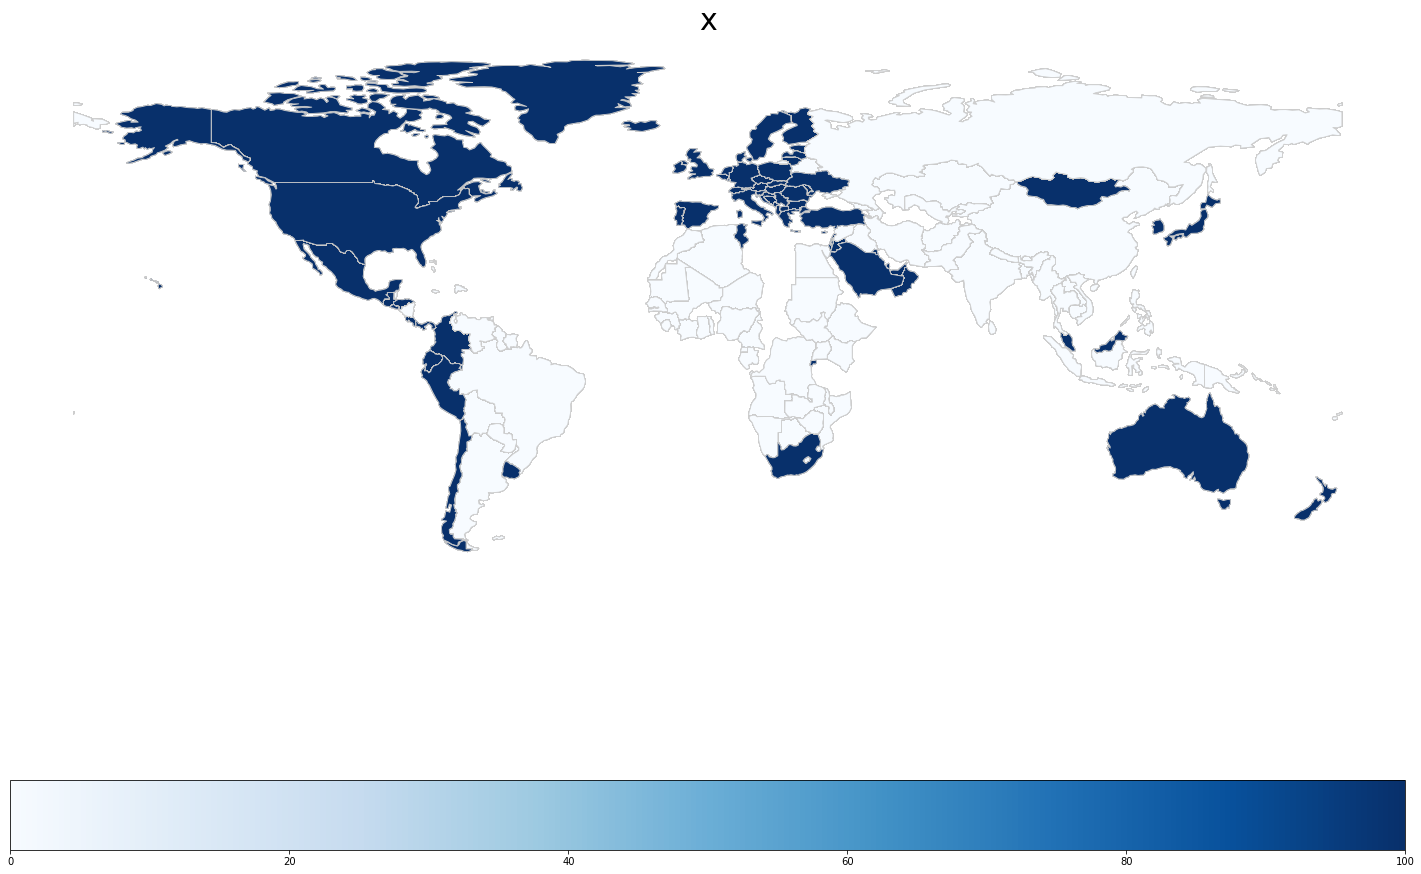

In [111]:
graph_world('American_Vaccine')

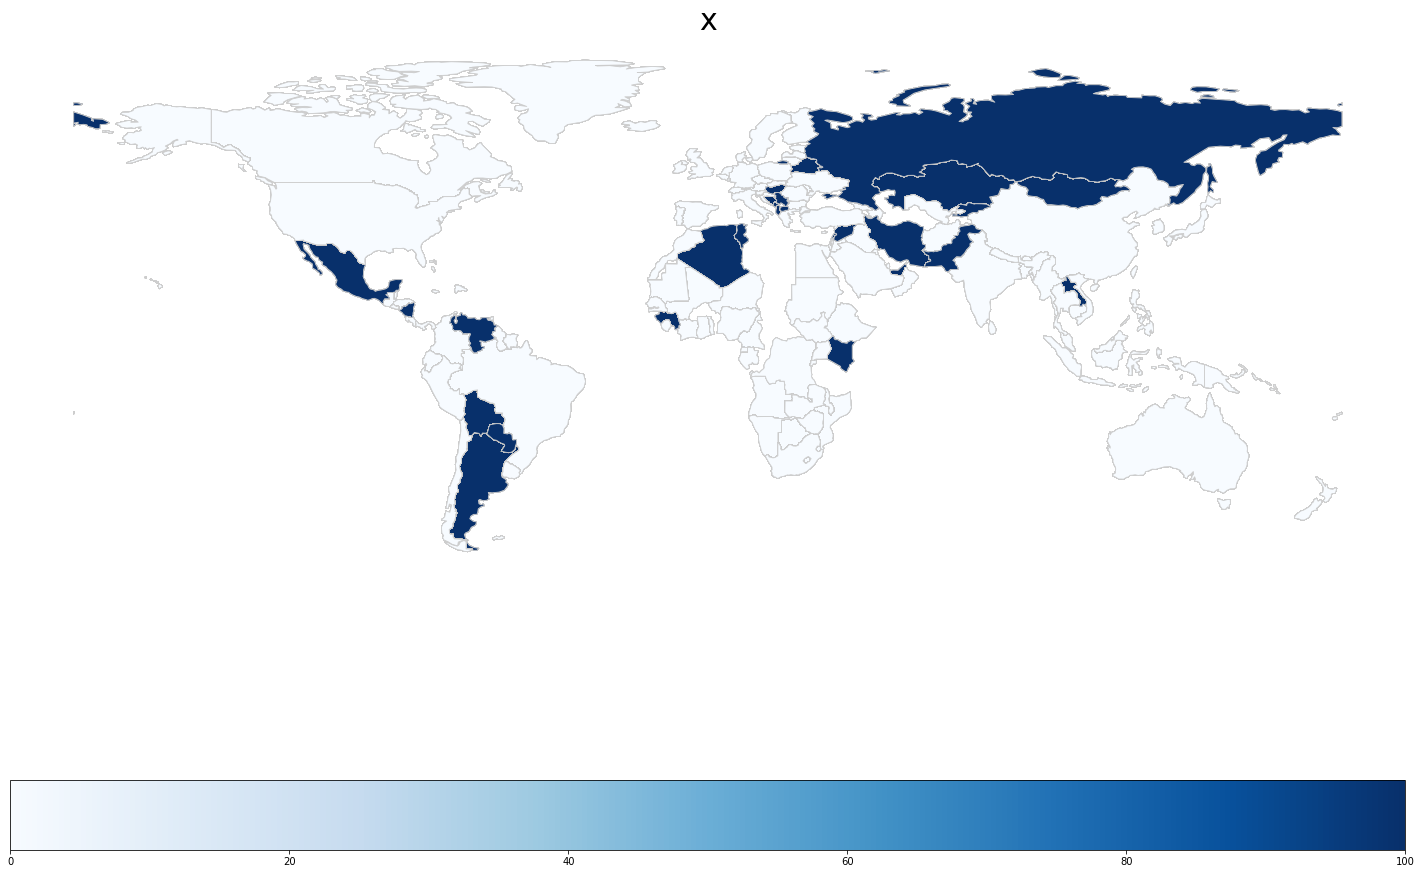

In [112]:
graph_world('Russian_Vaccine')

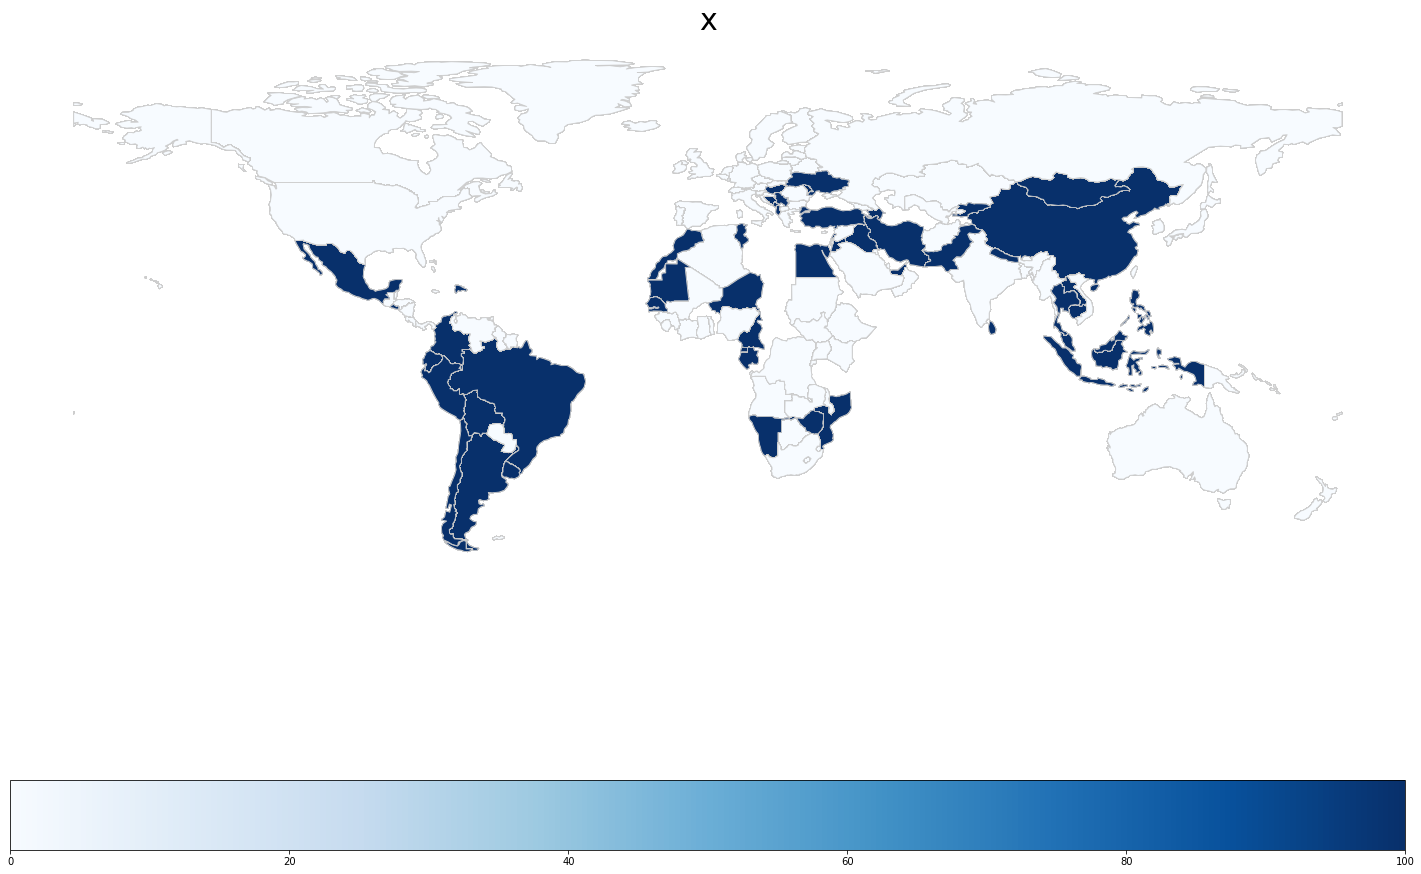

In [113]:
graph_world('Chinese_Vaccine')

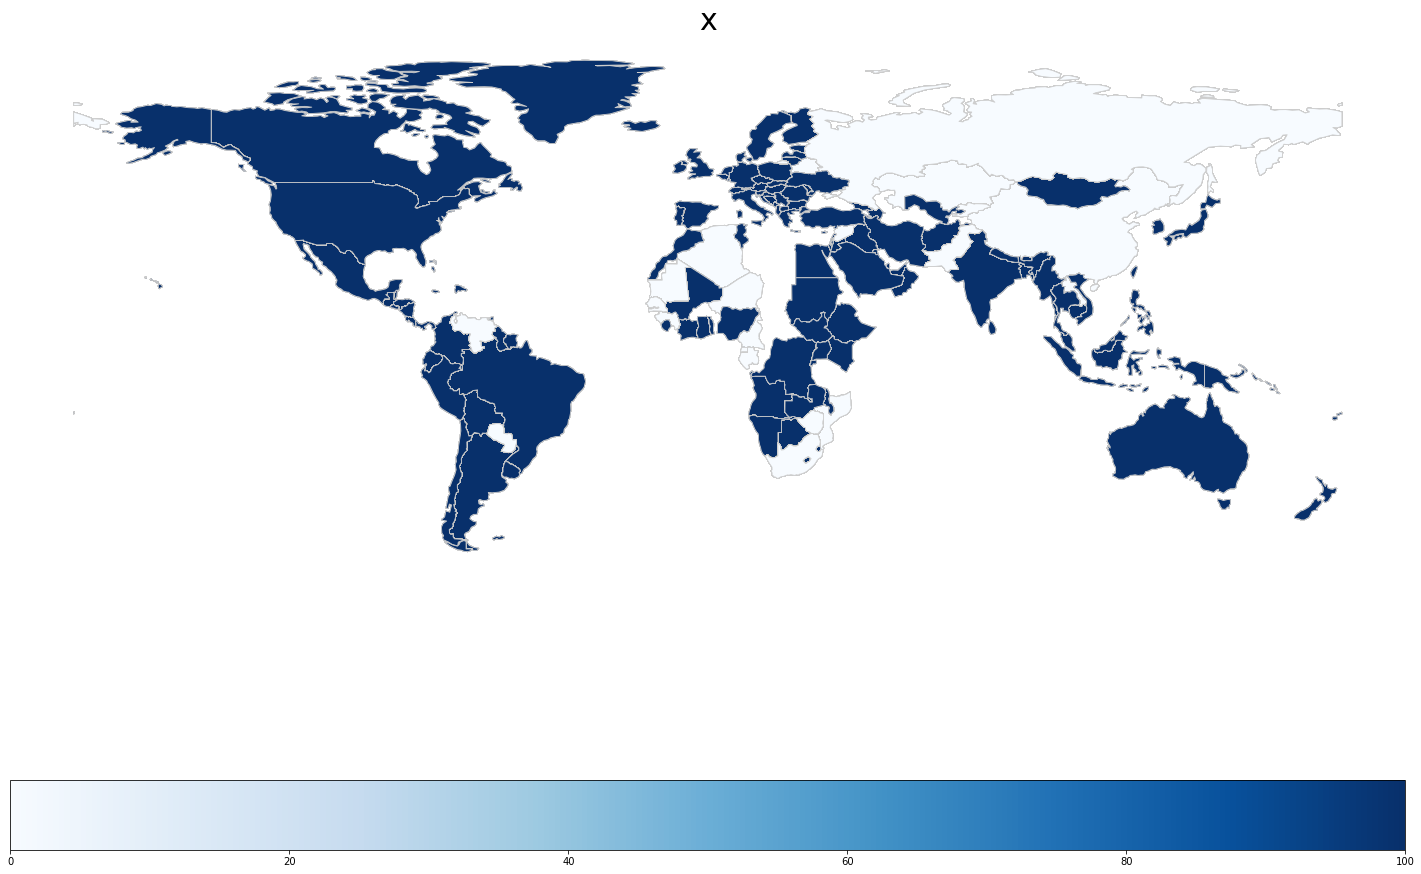

In [114]:
graph_world('European_Vaccine')

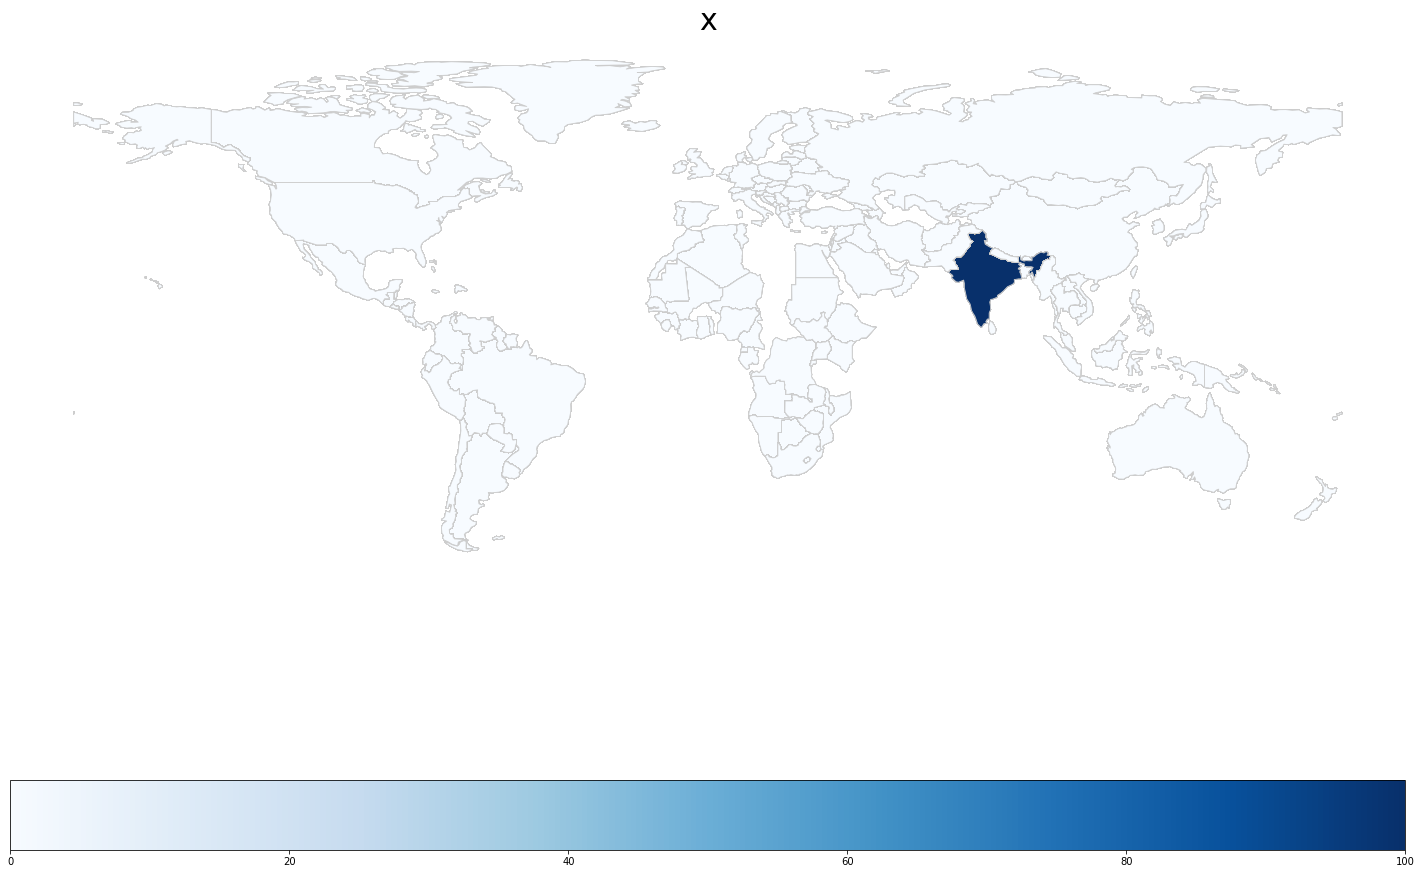

In [115]:
graph_world('Indian_Vaccine')

In [116]:
top_10_vacc = list(df_gm[(~df_gm['people_fully_vaccinated_per_hundred'].isna())&(df_gm['date']=='2021-03-28')].sort_values(by='people_fully_vaccinated_per_hundred',ascending=False).head(10)['iso_code'])

In [117]:
top_10_vacc

['GIB', 'ISR', 'ARE', 'MDV', 'CHL', 'USA', 'JEY', 'BHR', 'SRB', 'OWID_WLS']

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


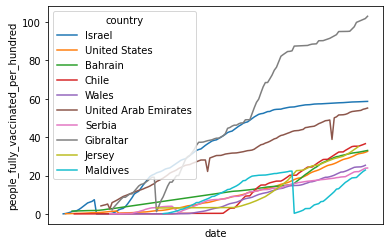

In [118]:
graph = sns.lineplot(data=df_gm[df_gm['iso_code'].isin(top_10_vacc)]
                     .sort_values(by="date"), x="date", y="people_fully_vaccinated_per_hundred",hue='country')
graph.xaxis.set_major_locator(md.DayLocator(interval = 7))
# graph.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%M:%D'))
plt.xticks(rotation = 90)

plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01   0.022454   -0.009511    0.054038
1 2021-02-01   0.011363   -0.018753    0.043885
2 2021-03-01   0.348573    0.316952    0.380077
3 2021-04-01   1.404859    1.372491    1.433037
4 2021-05-01   2.820818    2.790390    2.850975
5 2021-06-01   4.274080    4.153507    4.395209
6 2021-07-01   5.680211    5.270098    6.070082
7 2021-08-01   7.114209    6.323507    7.871472
8 2021-09-01   8.595066    7.356875    9.764644
9 2021-10-01  10.004071    8.222900   11.646687


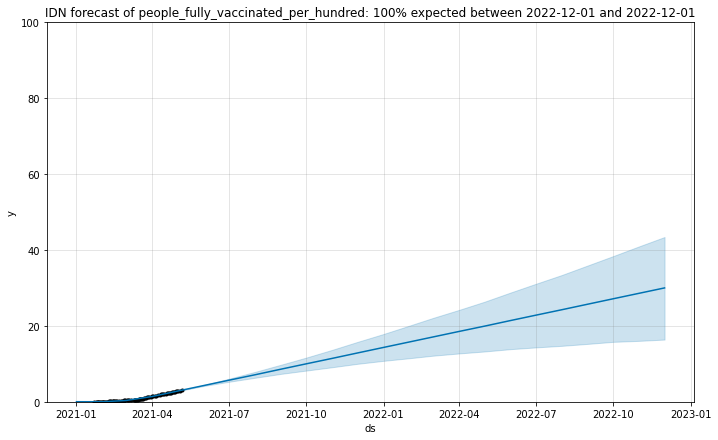

In [119]:
from fbprophet import Prophet
p = df_gm[df_gm['iso_code'].isin(['IDN'])].sort_values(by="date")[['date',"people_fully_vaccinated_per_hundred"]]
p.columns = ['ds', 'y']

# define the model
model = Prophet()
# # fit the model
model.fit(p)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2021-%02d' % i
    future.append([date])
for i in range(1, 13):
    date = '2022-%02d' % i
    future.append([date])    
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

# use the model to make a forecast
forecast = model.predict(future)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10))

# plot forecast
model.plot(forecast)
plt.ylim(0, 100)
n_lower=forecast['yhat_lower'].sub(100).abs().idxmin()
n_upper=forecast['yhat_upper'].sub(100).abs().idxmin()
plt.title('IDN' 
          + ' forecast of people_fully_vaccinated_per_hundred: 100% expected between ' 
          + forecast[n_upper:n_upper+1]['ds'].iloc[0].strftime('%Y-%m-%d') 
          + ' and ' 
          + forecast[n_lower:n_lower+1]['ds'].iloc[0].strftime('%Y-%m-%d'))
plt.show()

In [172]:
metric_df = forecast.set_index('ds')[['yhat']].join(p.set_index('ds').y).reset_index()

In [173]:
metric_df.tail()

,ds,yhat,y
100,2022-12-31,31.433224,NaN
101,2023-01-31,32.886487,NaN
102,2023-02-28,34.202000,NaN
103,2023-03-31,35.656573,NaN
104,2023-04-30,37.042129,NaN


In [175]:
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
76,2021-04-29,2.720307,2.77
77,2021-04-30,2.768749,2.80
78,2021-05-02,2.838792,2.82
79,2021-05-04,2.958567,2.93
80,2021-05-06,3.049185,3.05


In [182]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
r2_score(metric_df.y, metric_df.yhat)

0.9993510283131913

In [183]:
mean_squared_error(metric_df.y, metric_df.yhat)

0.0005875892918093922

In [184]:
mean_absolute_error(metric_df.y, metric_df.yhat)

0.018802947764770667

In [185]:
from sklearn.metrics import median_absolute_error
print(median_absolute_error(metric_df.y, metric_df.yhat))

0.015610653188337598


In [186]:
from math import sqrt
rmse = sqrt(mean_squared_error(metric_df.y, metric_df.yhat))
print(rmse)

0.024240241166485786
